In [183]:
import numpy as np
import time
# from tensorflow.examples.tutorials.mnist import input_data

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import img_to_array
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import cv2
import shutil
import warnings
warnings.filterwarnings('ignore')

In [178]:
meta = pd.read_csv('../data/HAM10k/HAM10000_metadata.csv')
meta_filtered = meta[meta['dx'] != 'nv' ]
meta_filtered

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


In [184]:
dest = '../data/HAM10k/minority/'
for i in tqdm(meta_filtered['image_id']):
    src = '../data/HAM10k/HAM10000_images/'+i+'.jpg'
    shutil.copy(src, dest)

100%|█████████████████████████████████████████████████████████████████████████████| 3310/3310 [00:18<00:00, 181.56it/s]


In [6]:


class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time) )



In [389]:
class SkinImageReader(object):
    def __init__(self, imagespath, row, col):
        self.image_paths = list(np.array(glob(imagespath)[:10]))
        self.row = row
        self.col = col
        
    def resize_image(self, imagePath, rows=28, cols=28):
        image = cv2.imread(imagePath, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (rows, cols))
        image = img_to_array(image)
        return image
        
    def read_images(self):
        data = []
        for imagePath in tqdm(self.image_paths):
            # load the image, pre-process it, and store it in the data list
            image =  self.resize_image(imagePath, self.row, self.col)
            data.append(image)
            # try:
            #     # image = self.resize_image(imagePath, self.rows, self.cols)
            #     image = cv2.imread(imagePath)
            #     data.append(image)
            # except Exception as e:
            #     print(f'{e}')
            #     # pass
           
        return data

In [390]:
ipaths = ['../data/HAM10k/minority/ISIC_0024310', '../data/HAM10k/minority/ISIC_0024312', '../data/HAM10k/minority/ISIC_0024313']

img = SkinImageReader(imagespath='../data/HAM10k/minority/*', row=100, col=100)
# img.image_paths
d = img.read_images()



100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 108.82it/s]


In [399]:
# cv2.imshow('image', d[1])
# cv2.waitKey(0)
# cv2.destroyAllWindows()


In [186]:
class DCGAN(object):
    def __init__(self, img_rows=100, img_cols=100, channel=1):

        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channel = channel
        self.D = None   # discriminator
        self.G = None   # generator
        self.AM = None  # adversarial model
        self.DM = None  # discriminator model

    # (W−F+2P)/S+1
    def discriminator(self):
        if self.D:
            return self.D
        self.D = Sequential()
        depth = 64
        dropout = 0.4
        # In: 28 x 28 x 1, depth = 1
        # Out: 14 x 14 x 1, depth=64
        input_shape = (self.img_rows, self.img_cols, self.channel)
        self.D.add(Conv2D(depth*1, 5, strides=2, input_shape=input_shape,\
            padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*2, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*4, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*8, 5, strides=1, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        # Out: 1-dim probability
        self.D.add(Flatten())
        self.D.add(Dense(1))
        self.D.add(Activation('sigmoid'))
        # self.D.summary()
        return self.D

    def generator(self):
        if self.G:
            return self.G
        self.G = Sequential()
        dropout = 0.4
        depth = 64+64+64+64
        dim = 7
        # In: 100
        # Out: dim x dim x depth
        self.G.add(Dense(dim*dim*depth, input_dim=100))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        self.G.add(Reshape((dim, dim, depth)))
        self.G.add(Dropout(dropout))

        # In: dim x dim x depth
        # Out: 2*dim x 2*dim x depth/2
        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        self.G.add(Conv2DTranspose(int(depth/8), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        # Out: 28 x 28 x 1 grayscale image [0.0,1.0] per pix
        self.G.add(Conv2DTranspose(1, 5, padding='same'))
        self.G.add(Activation('sigmoid'))
        # self.G.summary()
        return self.G

    def discriminator_model(self):
        if self.DM:
            return self.DM
        optimizer = RMSprop(lr=0.0002, decay=6e-8)
        self.DM = Sequential()
        self.DM.add(self.discriminator())
        self.DM.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.DM

    def adversarial_model(self):
        if self.AM:
            return self.AM
        optimizer = RMSprop(lr=0.0001, decay=3e-8)
        self.AM = Sequential()
        self.AM.add(self.generator())
        self.AM.add(self.discriminator())
        self.AM.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.AM

In [314]:
class skin_cancer_DCGAN(object):
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channel = 1
        
        
        
        self.datareader = SkinImageReader("../data/HAM10k/minority/*", 28, 28)
        # print('datareaeer initialized')
        # print(dir(self.datareader
        # self.resize = self.datareader.resize_image()
        self.x_train = self.datareader.read_images()
        
        self.DCGAN = DCGAN()
        self.discriminator =  self.DCGAN.discriminator_model()
        self.adversarial = self.DCGAN.adversarial_model()
        self.generator = self.DCGAN.generator()

    def train(self, train_steps=2000, batch_size=256, save_interval=0):
        noise_input = None
        if save_interval>0:
            noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
        for i in range(train_steps):
            images_train = self.x_train
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            # print(f"Noise Shape{noise.shape}")
            # print(f'x_train length:: {images_train}')
            images_fake = self.generator.predict(noise)
            x = np.concatenate((images_train, images_fake))
            # y = np.ones([2*batch_size, 1])
            y = np.ones([len(images_train)+batch_size, 1])
            y[batch_size:, :] = 0
            # print(f'x: {x.shape}, y: {y.shape}')
            d_loss = self.discriminator.train_on_batch(x, y)

            y = np.ones([batch_size, 1])
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            a_loss = self.adversarial.train_on_batch(noise, y)
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
            print(log_mesg)
            if save_interval>0:
                if (i+1)%save_interval==0:
                    self.plot_images_custom(save2file=True, samples=noise_input.shape[0],\
                        noise=noise_input, step=(i+1))
        

    def plot_images(self, save2file=False, fake=True, samples=16, noise=None, step=0):
        filename = 'skincancer.png'
        if fake:
            if noise is None:
                noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
            else:
                filename = "skincancer_%d.png" % step
            images = self.generator.predict(noise)
        else:
            i = np.random.randint(0, len(self.x_train), samples)
            images = self.x_train[i, :, :, :]

        plt.figure(figsize=(10,10))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.img_rows, self.img_cols])
            plt.imshow(image)
            plt.axis('off')
        plt.tight_layout()
        if save2file:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()
    
    def plot_images_custom(self, save2file=False, fake=True, samples=9, noise=None, step=0):
        filename = 'skincancer.png'
        if fake:
            if noise is None:
                noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
            else:
                filename = "skincancer_%d.png" % step
            images = self.generator.predict(noise)
        else:
            images = []
            i = np.random.randint(0, len(self.x_train), samples)
            # print(f'Index : {i}')
            # print(f' x-train length: {len(self.x_train)}, Index {i}: {self.x_train[0].shape}')
            # print(f' Type(xtrain):  {type(self.x_train)}, Type Index {i}: {type(self.x_train[i])}')
            for idx in i:
                images.append(self.x_train[idx])
            # images = self.x_train[i]

        plt.figure(figsize=(28,28))
        for i in range(0, len(images)):
            plt.subplot(3, 3, i+1)
            # print(images.shape)
            image = images[i]
            image = np.reshape(image, [self.img_rows, self.img_cols])
            plt.imshow(image)
            plt.axis('off')
        plt.tight_layout()
        if save2file:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()

In [311]:
# if __name__ == '__main__':
skin_cancer_dcgan = skin_cancer_DCGAN()
timer = ElapsedTimer()

# Save Model
# skin_cancer_dcgan.save('../models/model_GAN')



8/8 [==============================] - 1s 81ms/step
x: (47252, 28, 28, 1), y: (47252, 1)
0: [D loss: 2.794586, acc: 0.466414]  [A loss: 1.127752, acc: 0.000000]
8/8 [==============================] - 1s 101ms/step
x: (47252, 28, 28, 1), y: (47252, 1)
1: [D loss: 0.217496, acc: 0.994582]  [A loss: 0.723831, acc: 0.000000]
8/8 [==============================] - 1s 108ms/step
x: (47252, 28, 28, 1), y: (47252, 1)
2: [D loss: 20.864525, acc: 0.005545]  [A loss: 0.903692, acc: 0.000000]
8/8 [==============================] - 1s 107ms/step
x: (47252, 28, 28, 1), y: (47252, 1)
3: [D loss: 0.430530, acc: 0.994582]  [A loss: 0.771114, acc: 0.000000]
8/8 [==============================] - 1s 109ms/step
x: (47252, 28, 28, 1), y: (47252, 1)
4: [D loss: 0.229142, acc: 0.994582]  [A loss: 0.723969, acc: 0.000000]
8/8 [==============================] - 1s 108ms/step
x: (47252, 28, 28, 1), y: (47252, 1)
5: [D loss: 0.099748, acc: 0.981630]  [A loss: 0.700577, acc: 0.109375]
8/8 [=======================

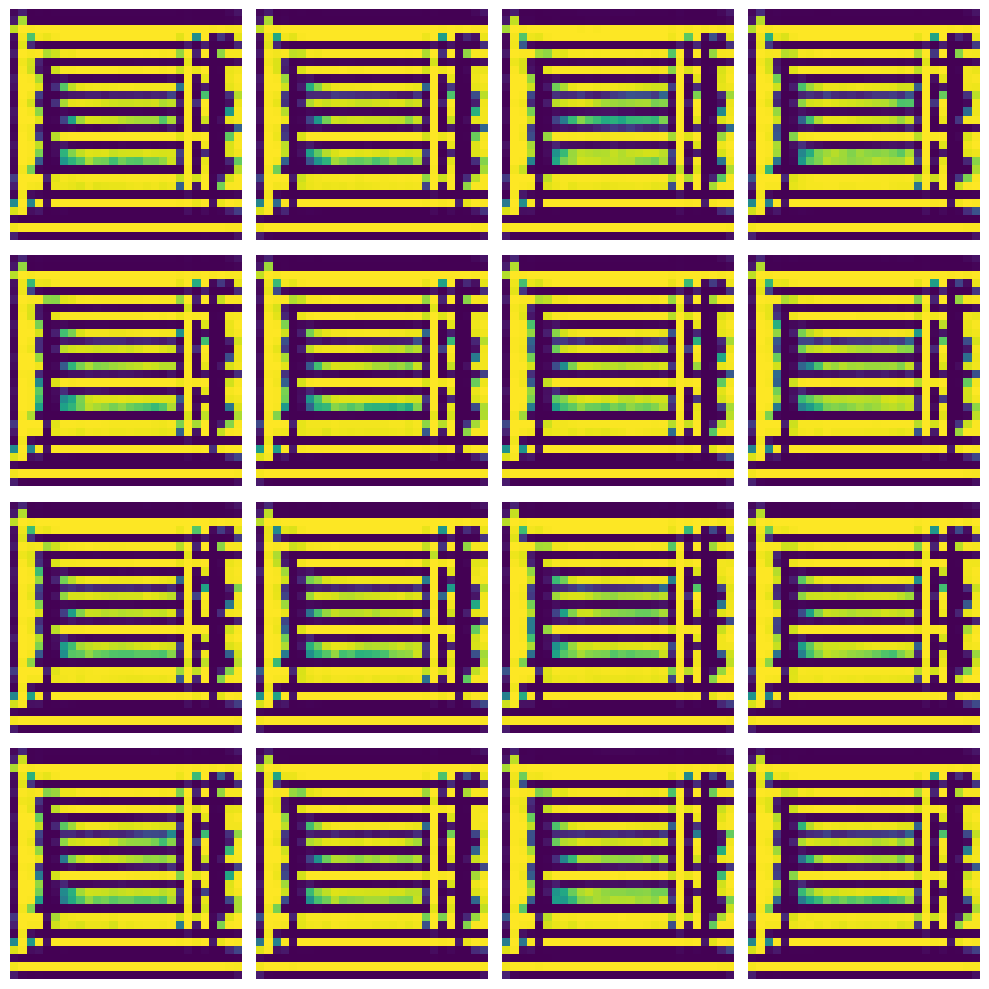

TypeError: list indices must be integers or slices, not tuple

In [168]:
skin_cancer_dcgan.train(train_steps=500, batch_size=256, save_interval=500)
timer.elapsed_time()
skin_cancer_dcgan.plot_images(fake=True)
skin_cancer_dcgan.plot_images(fake=False, save2file=True)

In [353]:
skin_cancer_dcgan2= skin_cancer_DCGAN()
timer2 = ElapsedTimer()
skin_cancer_dcgan2.train(train_steps=10, batch_size=256, save_interval=500)
timer2.elapsed_time()
skin_cancer_dcgan2.plot_images_custom(fake=False, save2file=True)

100%|█████████████████████████████████████████████████████████████████████████████| 3310/3310 [00:24<00:00, 134.59it/s]


8/8 [==============================] - 2s 248ms/step
0: [D loss: 1.363527, acc: 0.693494]  [A loss: 1.097569, acc: 0.000000]
8/8 [==============================] - 2s 205ms/step
1: [D loss: 2.691932, acc: 0.928211]  [A loss: 0.608292, acc: 1.000000]
8/8 [==============================] - 2s 206ms/step
2: [D loss: 139.061203, acc: 0.071789]  [A loss: 0.704279, acc: 0.003906]
8/8 [==============================] - 2s 227ms/step
3: [D loss: 5.620587, acc: 0.090017]  [A loss: 0.753259, acc: 0.000000]
8/8 [==============================] - 2s 225ms/step
4: [D loss: 2.013041, acc: 0.928211]  [A loss: 0.712103, acc: 0.000000]
8/8 [==============================] - 2s 234ms/step
5: [D loss: 0.667770, acc: 0.925126]  [A loss: 0.689653, acc: 0.812500]
8/8 [==============================] - 2s 205ms/step
6: [D loss: 6.472040, acc: 0.086371]  [A loss: 0.725105, acc: 0.000000]
8/8 [==============================] - 2s 192ms/step
7: [D loss: 1.866590, acc: 0.928211]  [A loss: 0.695272, acc: 0.343750

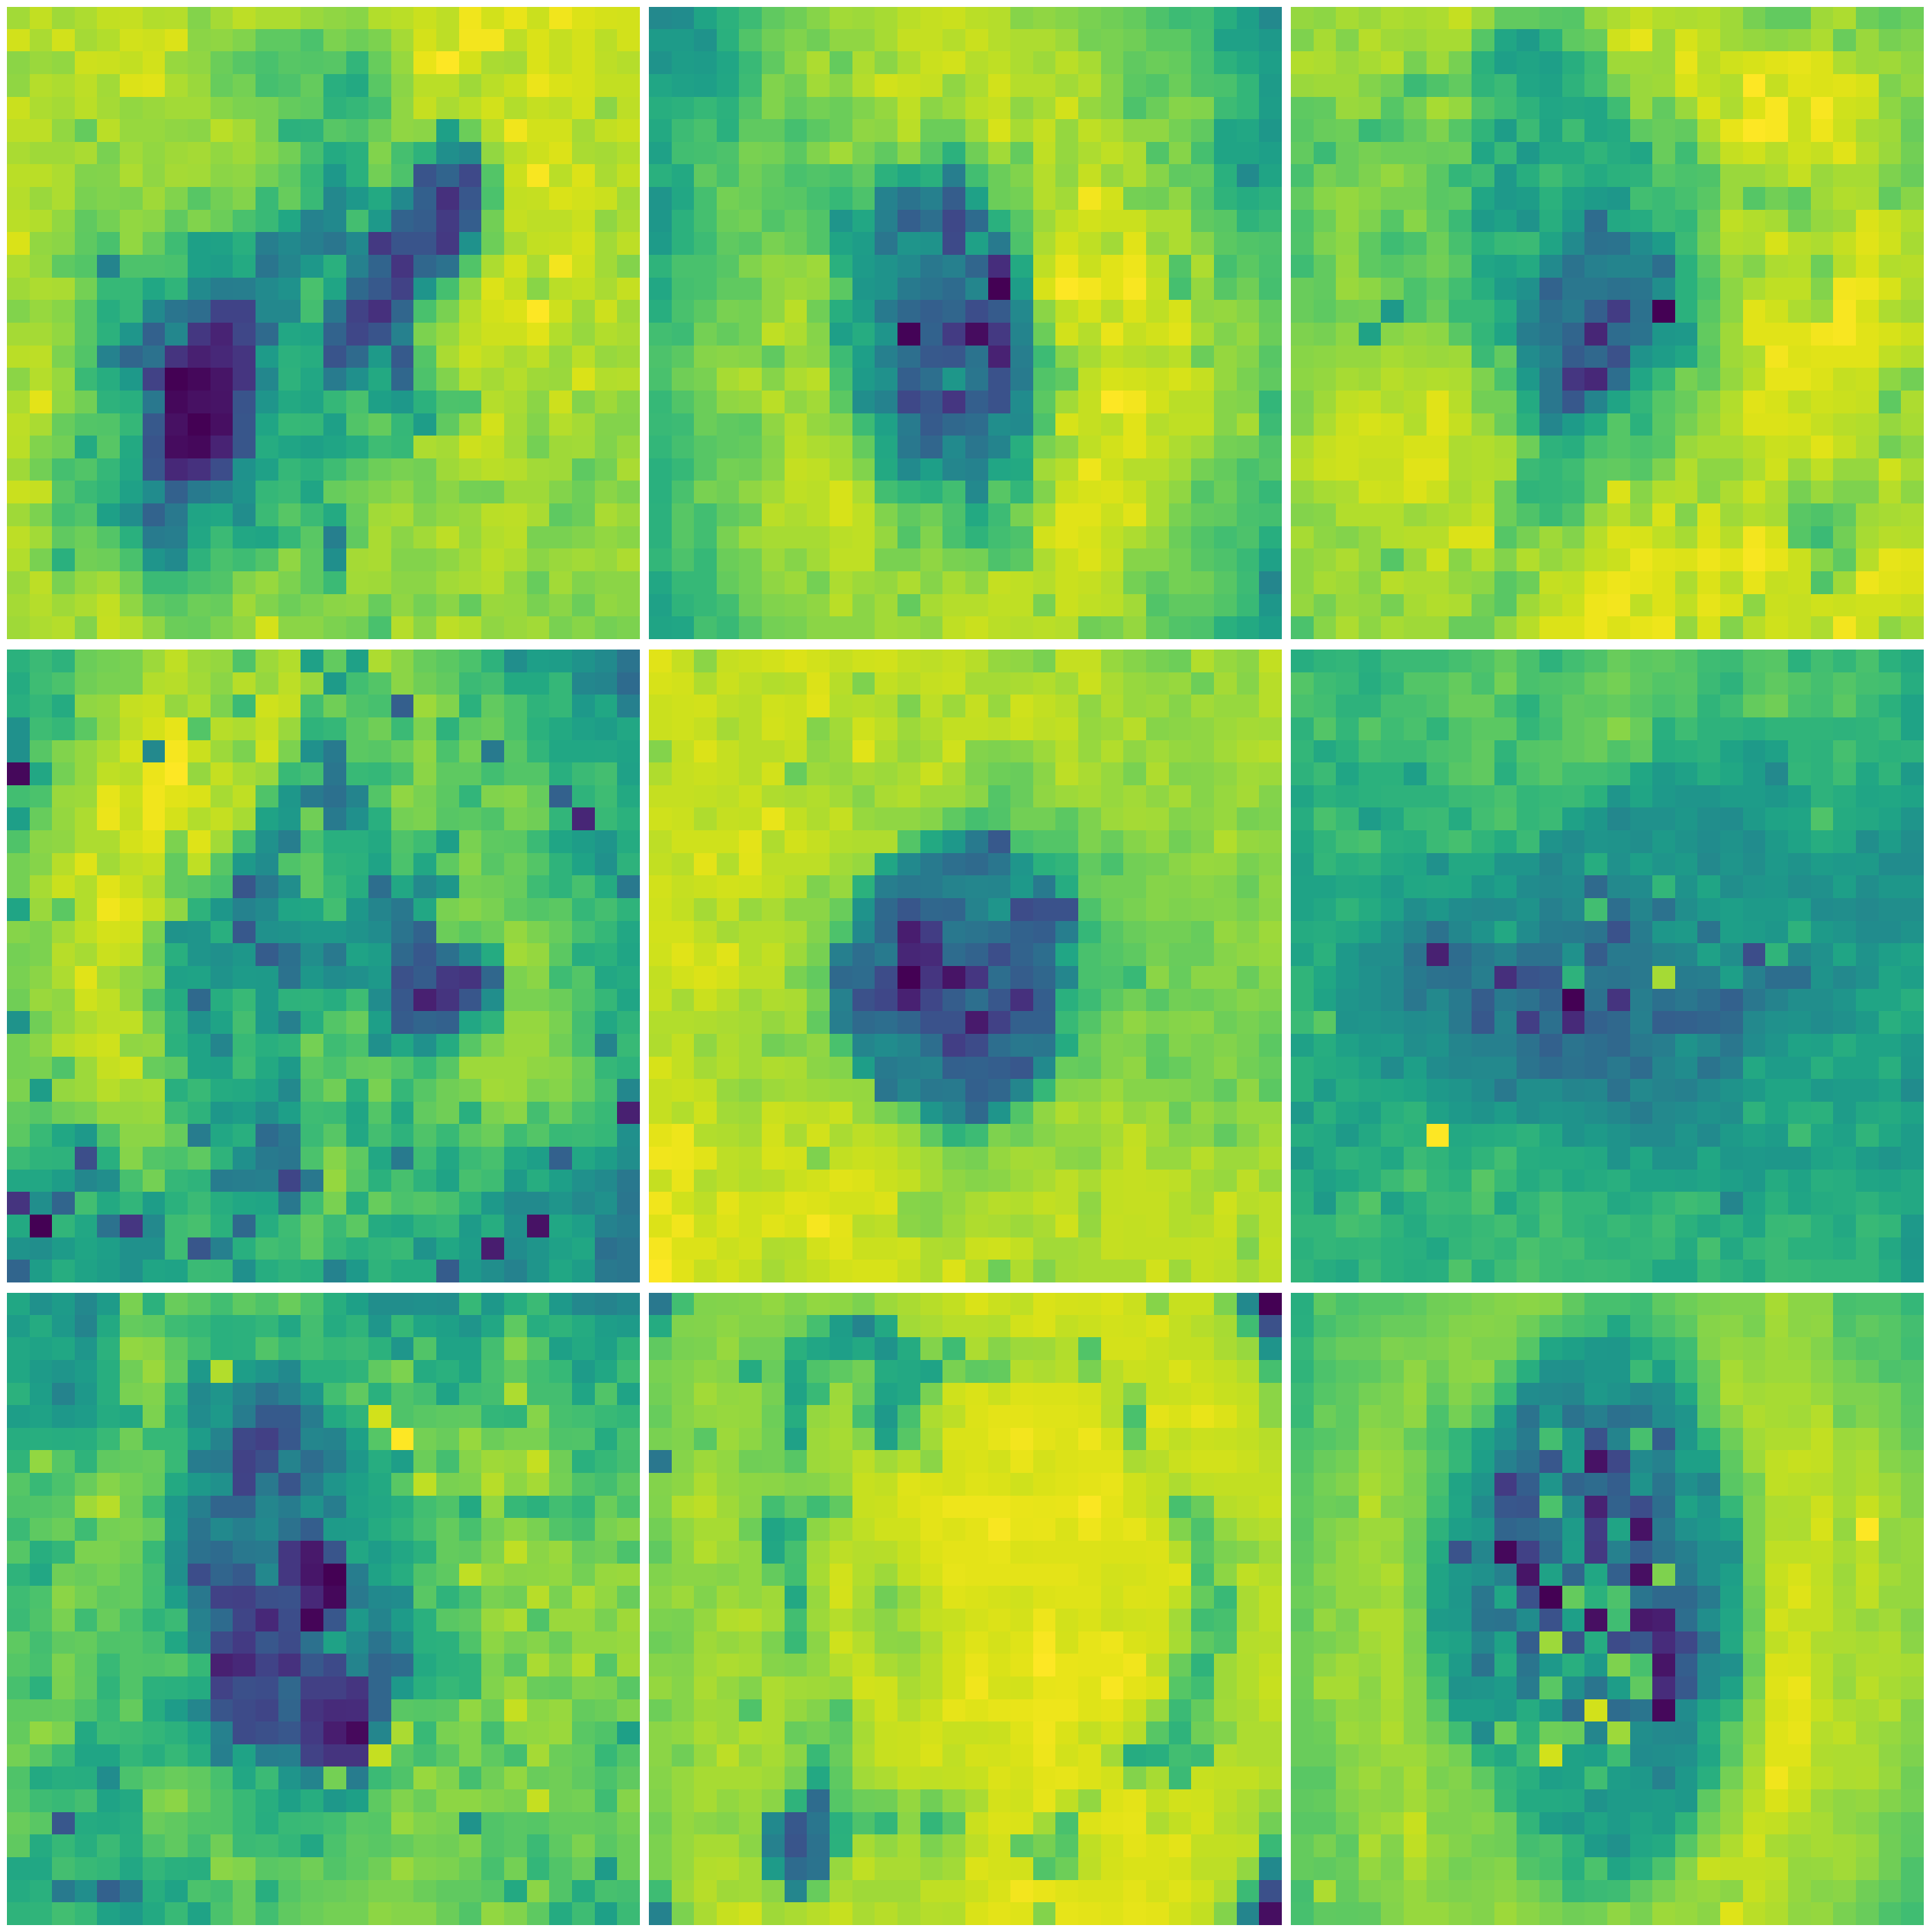

In [357]:
skin_cancer_dcgan2.plot_images_custom(fake=False)

## Generative Adversrial Network :: PyTorch